In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path
import time

https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632

In [2]:
# annotation_file = Path("./birdclef-2022/train_metadata.csv")
annotation_file = Path("./train_spectrograms.csv")

data_dir = Path("./birdclef-2022/spectograms_full/")

dataframe = pd.read_csv(annotation_file)
dataframe.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename,file_path
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,XC125458_5,birdclef-2022\spectograms_full\afrsil1\XC125458_5
1,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,XC125458_10,birdclef-2022\spectograms_full\afrsil1\XC12545...
2,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,XC125458_15,birdclef-2022\spectograms_full\afrsil1\XC12545...
3,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,XC175522_5,birdclef-2022\spectograms_full\afrsil1\XC175522_5
4,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,XC175522_10,birdclef-2022\spectograms_full\afrsil1\XC17552...


## loading data

In [3]:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, data_dir, transform=None, target_transform=None):
        self.labels = pd.read_csv(annotations_file)
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = self.labels.iloc[idx]
        img_path = data_dir / item.primary_label / (item.filename + ".npy")
        spect = np.load(img_path)
        label = self.labels.iloc[idx].primary_label
        if self.transform:
            spect = self.transform(spect)
            # spect.transpose_(0, 2).transpose_(0, 1)
        if self.target_transform:
            label = self.target_transform([label])
        return spect, label

In [4]:
class OneHotEncoder():
  def __init__(self, classes):
    self.num_classes = len(classes)
    self.classes = {}
    for i, c in enumerate(classes):
      self.classes[c] = i

  def transform(self, vals):
    xs = []
    for val in vals:
      x = np.zeros(self.num_classes)
      x[self.classes[val]] = 1
      xs.append(x)
    return xs

classes = list("abcd")
encoder = OneHotEncoder(classes)
encoder.transform("b")

[array([0., 1., 0., 0.])]

In [5]:
from sklearn.preprocessing import LabelEncoder

classes = dataframe.primary_label.unique()
le = LabelEncoder()
le.fit(classes)

dataset = CustomDataset(
    annotations_file = annotation_file,
    data_dir = data_dir,
    transform = transforms.ToTensor(),
    target_transform = le.transform
)

In [6]:
len(dataset) * 0.8, len(dataset)

(115876.0, 144845)

In [7]:
batch_size = 48
num_images = len(dataset)
num_training = num_images * 4 // 5
num_validation = num_images // 5
data_split = [num_training, num_validation]
seed = generator=torch.Generator().manual_seed(42)
train_set, val_set = torch.utils.data.random_split(dataset, data_split, seed)
train_dataloader = DataLoader(train_set, batch_size=batch_size)
val_dataloader = DataLoader(val_set, batch_size=batch_size)

Feature batch shape: torch.Size([48, 1, 224, 313])
Labels batch shape: 48


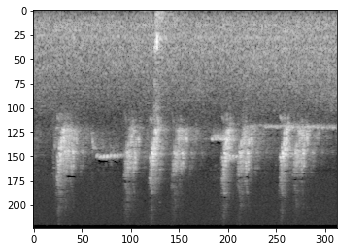

Label: tensor([68])


In [8]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
idx = 30
img = train_features[idx].squeeze()
label = train_labels[idx]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Model architecture

In [10]:
import math
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [152]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)

        tmp = torch.cos(position * div_term)
        
        if (d_model % 2 == 0):
            pe[:, 0, 1::2] = tmp
        else:
            # FIXME make sure that it makes sense to delete last entry of array
            pe[:, 0, 1::2] = tmp[:, :-1]

        
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [153]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, n_classes: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        # self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, d_model)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        # self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        # src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output

class Net(nn.Module):
    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, n_classes: int, dropout: float = 0.5):
        super().__init__()
        self.transformer = TransformerModel(ntoken =  ntoken,
                            d_model = d_model,
                            nhead = nhead,
                            d_hid = d_hid,
                            nlayers = nlayers,
                            n_classes = n_classes)#.to(device)
                
        self.linear = nn.Linear(ntoken * d_model, n_classes)

    def forward(self, x: Tensor) -> Tensor:
        x = self.transformer(x)
        # pool over d_model
        
        x.swapaxes_(0, 1)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return F.softmax(x)


# preprocess a 5-second chunk
train_features, train_labels = next(iter(train_dataloader))
train_features.squeeze_()
print(f"Feature batch shape: {train_features.size()}")
ntoken = 313#train_features.size()[2]
d_model = train_features.size()[1]

n_classes = len(dataframe.primary_label.unique())
d_hid = 200 # dimension of the feed-forward network model in nn.TransformerEncoder
nlayers = 1 # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 1 # number of heads in nn.MultiheadAttention
dropout = 0.2 # dropout probability
print(f"ntoken {ntoken}, d_model {d_model}")
model = Net(ntoken =  ntoken,
                        d_model = d_model,
                        nhead = nhead,
                        d_hid = d_hid,
                        nlayers = nlayers,
                        n_classes = n_classes).to(device)
model

Feature batch shape: torch.Size([48, 224, 313])
ntoken 313, d_model 224


Net(
  (transformer): TransformerModel(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=224, out_features=224, bias=True)
          )
          (linear1): Linear(in_features=224, out_features=200, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=200, out_features=224, bias=True)
          (norm1): LayerNorm((224,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((224,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
      )
    )
    (decoder): Linear(in_features=224, out_features=224, bias=True)
  )
  (linear): Linear(in_features=70112, out_features=15

In [31]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        dropout_rate = 0.6
        kernel_size = 5
        stride = (1,2)

        # Convolutional layers with max pooling
        self.conv1 = nn.Conv2d(1, 10, kernel_size, stride=stride)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 16, kernel_size, stride=stride)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 16, kernel_size, stride=stride)
        self.global_average = nn.AvgPool2d((3, 3))

        # Dense layers with dropout
        self.dense1 = nn.Linear(16*16*2, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dense2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dense3 = nn.Linear(512, n_classes)

    def forward(self, x):

        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.global_average(x)

        # Dense layers
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.dense1(x))
        x = self.dropout1(x)
        x = F.relu(self.dense2(x))
        x = self.dropout2(x)
        x = self.dense3(x)
        return x

n_classes = len(dataframe.primary_label.unique())
model = CNN(n_classes).to(device)
model

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 16, kernel_size=(5, 5), stride=(1, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 2))
  (global_average): AvgPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0)
  (dense1): Linear(in_features=512, out_features=512, bias=True)
  (dropout1): Dropout(p=0.6, inplace=False)
  (dense2): Linear(in_features=512, out_features=512, bias=True)
  (dropout2): Dropout(p=0.6, inplace=False)
  (dense3): Linear(in_features=512, out_features=152, bias=True)
)

In [32]:
from torchsummary import summary

summary(model, (1, 224, 313), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 220, 155]             260
         MaxPool2d-2          [-1, 10, 110, 77]               0
            Conv2d-3          [-1, 16, 106, 37]           4,016
         MaxPool2d-4           [-1, 16, 53, 18]               0
            Conv2d-5            [-1, 16, 49, 7]           6,416
         AvgPool2d-6            [-1, 16, 16, 2]               0
            Linear-7                  [-1, 512]         262,656
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 512]         262,656
          Dropout-10                  [-1, 512]               0
           Linear-11                  [-1, 152]          77,976
Total params: 613,980
Trainable params: 613,980
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.27
Forward/

In [33]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [34]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

wandb.init(project="birdclef", config = {"model": "CNN"})

loss,█▁▁▁▁▁
val_loss,▁▁▁▁▁▁
loss,4.96168
val_loss,4.96163


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [35]:
%%wandb

losses = []
val_losses = []

epoch_losses = []
epoch_val_losses = []

start_time = time.time()

print("Started Training")

for epoch in range(30):  # loop over the dataset multiple times

    epoch_start_time = time.time()

    running_loss = 0.0    
    running_loss_count = 0

    model.train()     # Optional when not using Model Specific layer
    for inputs, labels in train_dataloader:
        if device.type == 'cuda':
            inputs, labels = inputs.cuda(), labels.cuda()
            labels = labels.type(torch.LongTensor).to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()

        losses.append(loss)

        running_loss += loss.item()
        running_loss_count += 1

    val_running_loss = 0.0
    val_running_loss_count = 0

    model.eval()     # Optional when not using Model Specific layer
    for inputs, labels in val_dataloader:
        if device.type == 'cuda':
            inputs, labels = inputs.cuda(), labels.cuda()
            labels = labels.type(torch.LongTensor).to(device)

        with torch.no_grad():
            target = model(inputs)
            val_loss = criterion(target, labels.squeeze())
            val_losses.append(val_loss)

            val_running_loss += val_loss.item()
            val_running_loss_count += 1

    epoch_loss = running_loss / running_loss_count
    epoch_val_loss = val_running_loss / val_running_loss_count

    epoch_losses.append(epoch_loss)
    epoch_val_losses.append(epoch_val_loss)

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time

    wandb.log({"loss": epoch_loss})
    wandb.log({"val_loss": epoch_val_loss})

    print(f'Epoch [{epoch + 1}] = time {epoch_time:.1f}s | loss: {epoch_loss:.3f} | val loss: {epoch_val_loss:.3f}')

    # Early Stopping
    rising = all(epoch_val_losses[-i] > epoch_val_losses[-(i+1)] for i in range(5))
    if rising:
        print("Validation loss has been rising. Stopping")
        break

end_time = time.time()
total_time = end_time - start_time

print(f'Finished Training (took {total_time:.1f}s')

Started Training
Epoch [1] = time 135.3s | loss: 3.596 | val loss: 2.986
Epoch [2] = time 139.5s | loss: 2.930 | val loss: 2.547
Epoch [3] = time 139.8s | loss: 2.667 | val loss: 2.343
Epoch [4] = time 134.2s | loss: 2.509 | val loss: 2.219
Epoch [5] = time 129.3s | loss: 2.399 | val loss: 2.099
Epoch [6] = time 138.1s | loss: 2.316 | val loss: 2.073
Epoch [7] = time 138.3s | loss: 2.257 | val loss: 1.956
Epoch [8] = time 120.6s | loss: 2.203 | val loss: 1.919
Epoch [9] = time 121.2s | loss: 2.162 | val loss: 1.908
Epoch [10] = time 99.9s | loss: 2.119 | val loss: 1.869
Epoch [11] = time 97.4s | loss: 2.094 | val loss: 1.854
Epoch [12] = time 98.9s | loss: 2.062 | val loss: 1.763
Epoch [13] = time 97.5s | loss: 2.044 | val loss: 1.768
Epoch [14] = time 94.2s | loss: 2.012 | val loss: 1.746
Epoch [15] = time 96.4s | loss: 1.994 | val loss: 1.761
Epoch [16] = time 96.1s | loss: 1.983 | val loss: 1.718
Epoch [17] = time 97.5s | loss: 1.967 | val loss: 1.712
Epoch [18] = time 97.0s | loss:

In [ ]:
print(val_losses[0].type)

<built-in method type of Tensor object at 0x000001A9364B7BD0>


In [ ]:
detached_losses = [ l.cpu().detach().numpy() for l in losses ]
detached_val_losses = [ l.cpu().detach().numpy() for l in val_losses ]
np.save("losses", detached_losses)
np.save("val_losses", detached_val_losses)
np.save("model", model.cpu())

Text(0.5, 1.0, 'Transformer loss')

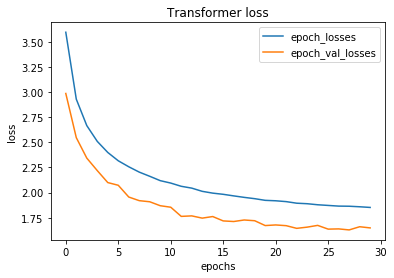

In [37]:
plt.plot(epoch_losses, label='epoch_losses')
plt.plot(epoch_val_losses, label='epoch_val_losses')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Transformer loss")

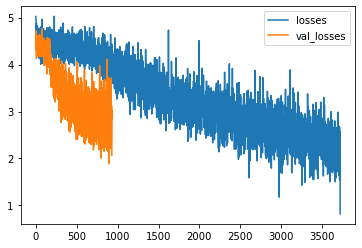

In [ ]:
plt.plot(np.arange(len(losses)), list(map(lambda x: x.cpu().detach().numpy(), losses)), label='losses')
plt.plot(np.arange(len(val_losses)), list(map(lambda x: x.cpu().detach().numpy(), val_losses)), label='val_losses')
plt.legend()

In [39]:
correct = 0
for inputs, labels in val_dataloader:
    if device.type == 'cuda':
        inputs, labels = inputs.cuda(), labels.cuda()

    with torch.no_grad():
        output = model(inputs)
        _, idxs = output.topk(1, dim=1)
        correct += (idxs == labels).float().sum()

accuracy = 100 * correct / (len(val_dataloader) * batch_size)

print("Accuracy = {}".format(accuracy))

Accuracy = 62.055049896240234


In [40]:
model_path = "models/cnn_v1.pt"
torch.save(model.state_dict(), model_path)